<a href="https://colab.research.google.com/github/akhilseshan/MalayalamHandwritingRecognition/blob/master/word_and_character_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

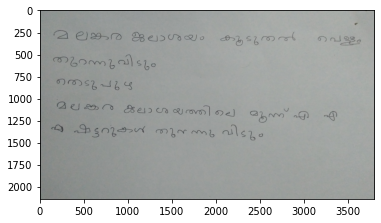

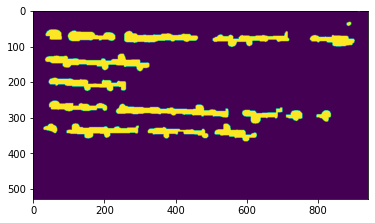

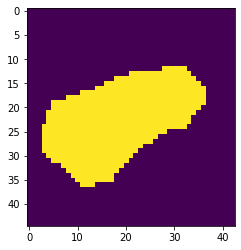

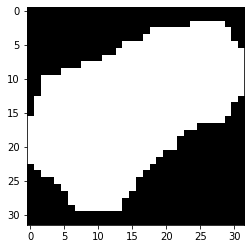

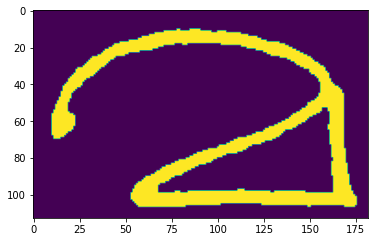

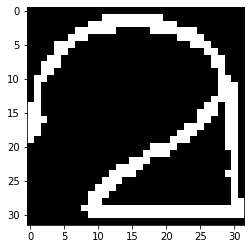

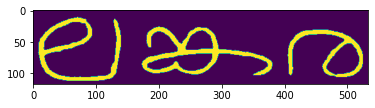

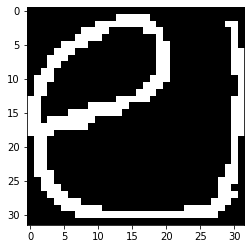

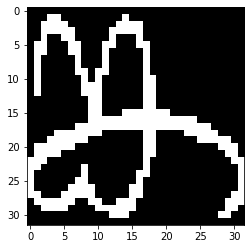

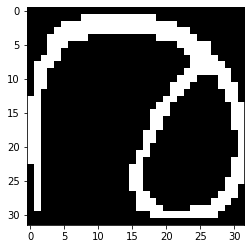

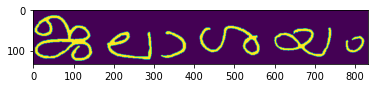

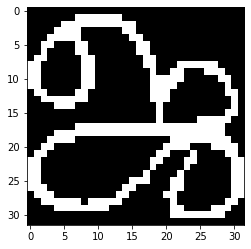

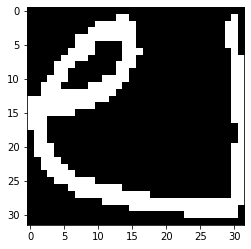

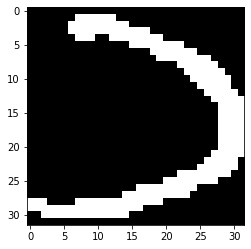

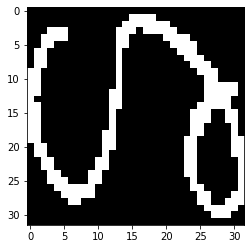

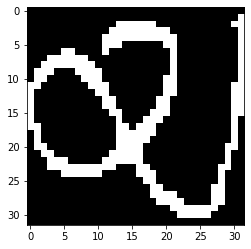

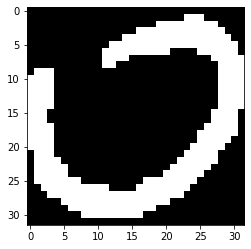

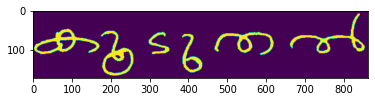

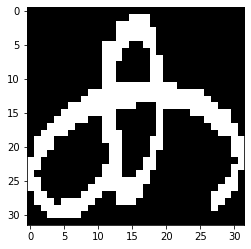

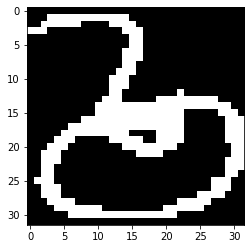

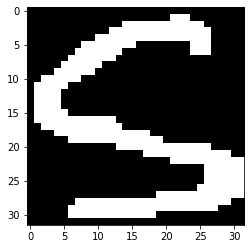

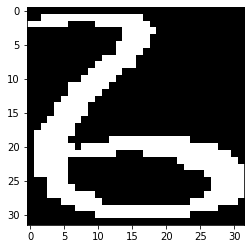

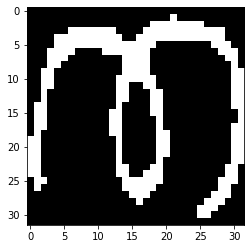

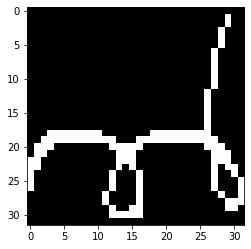

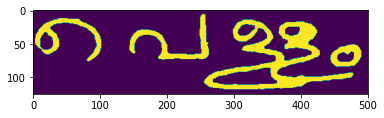

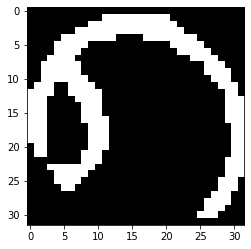

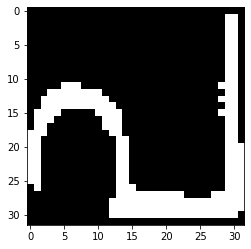

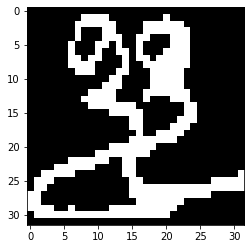

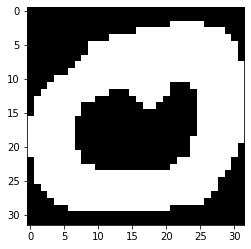

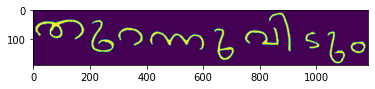

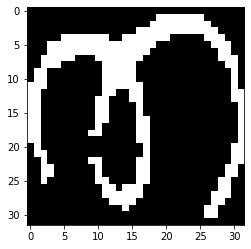

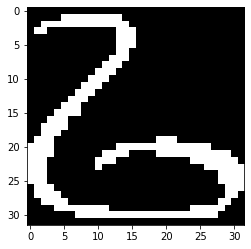

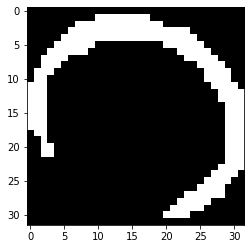

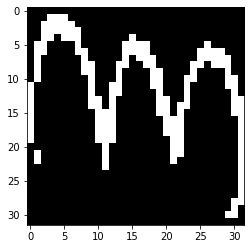

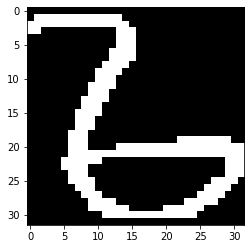

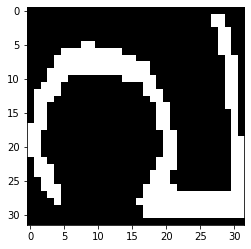

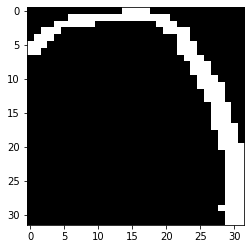

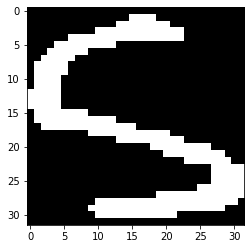

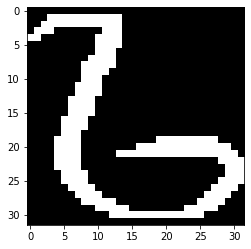

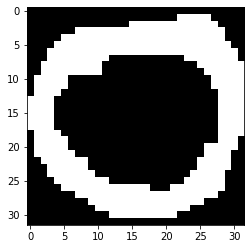

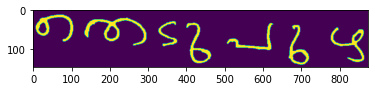

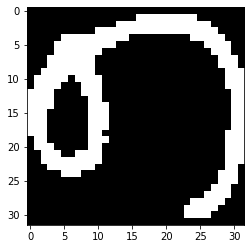

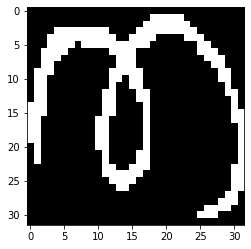

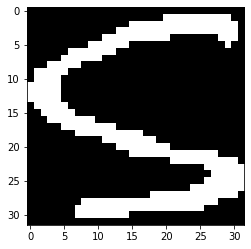

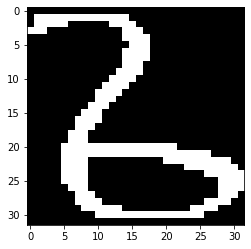

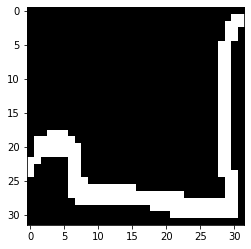

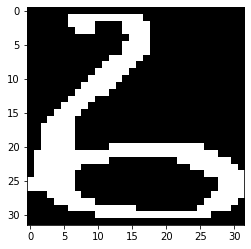

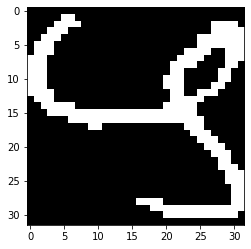

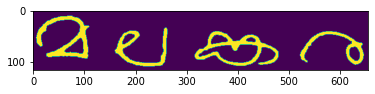

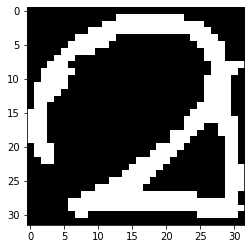

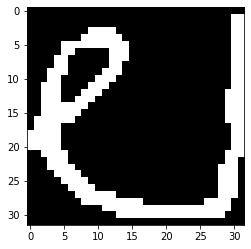

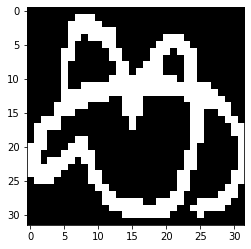

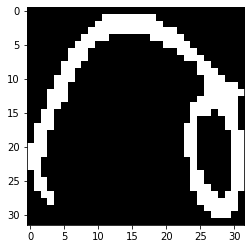

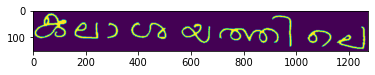

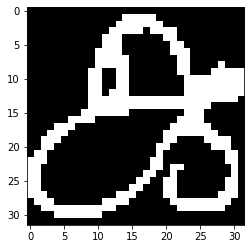

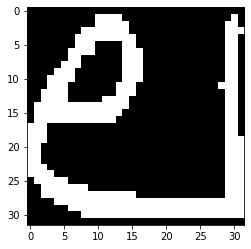

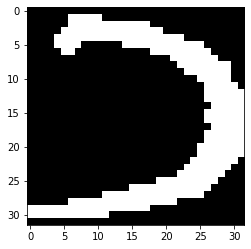

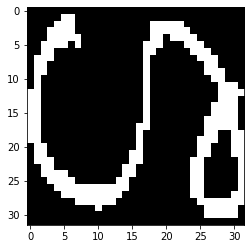

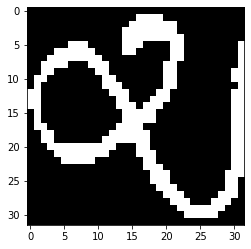

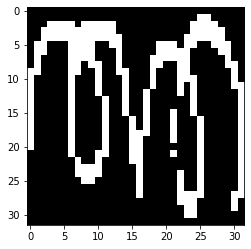

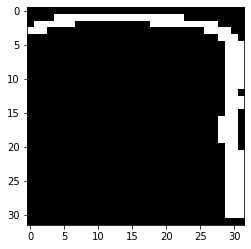

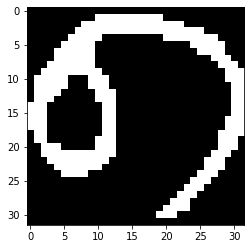

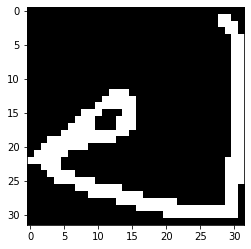

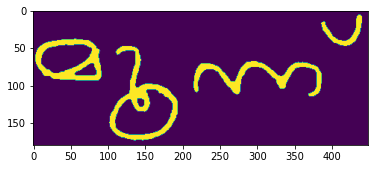

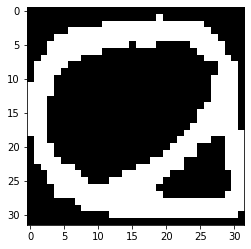

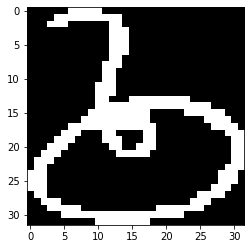

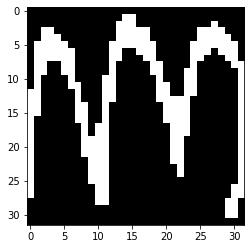

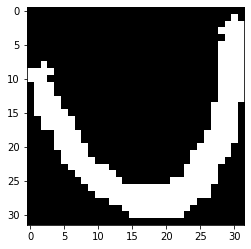

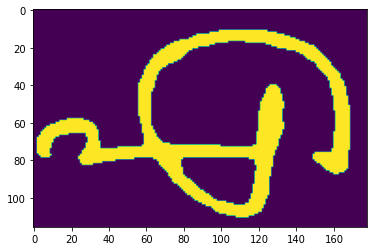

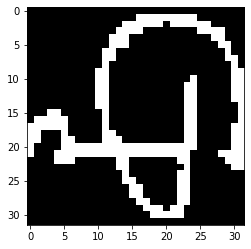

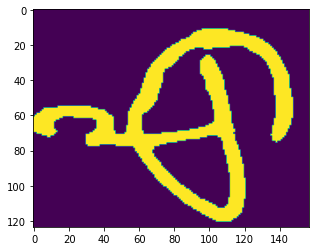

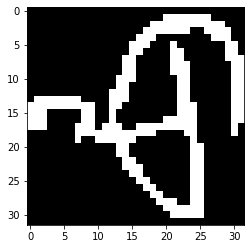

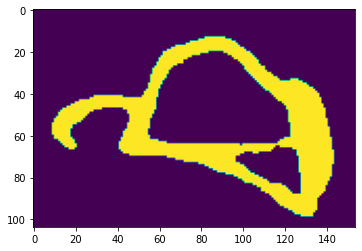

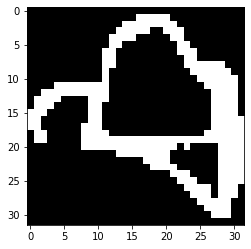

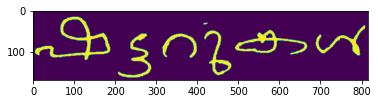

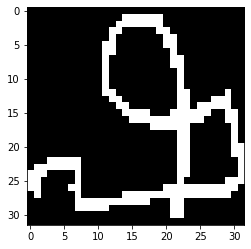

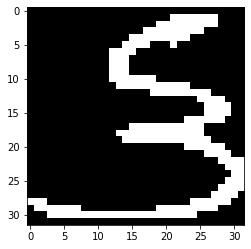

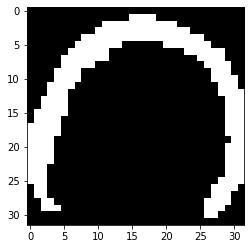

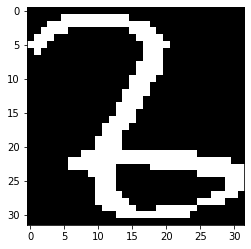

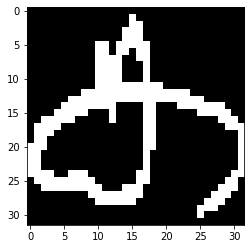

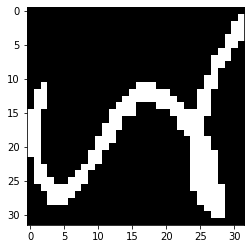

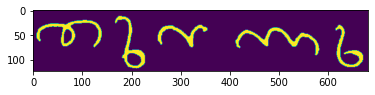

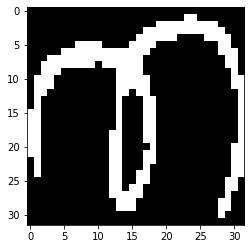

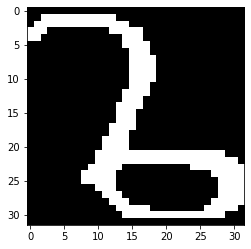

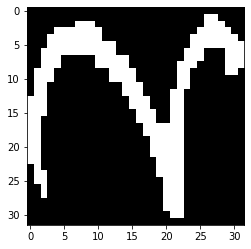

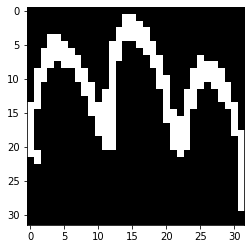

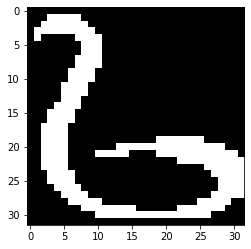

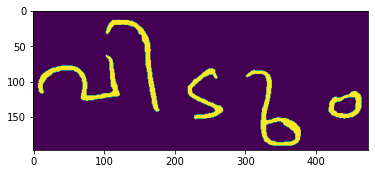

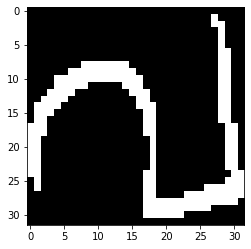

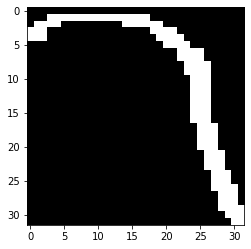

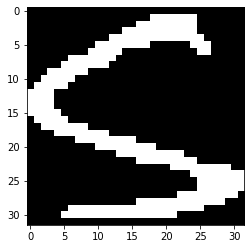

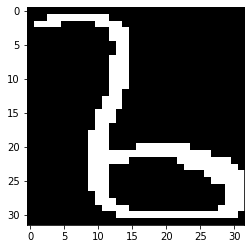

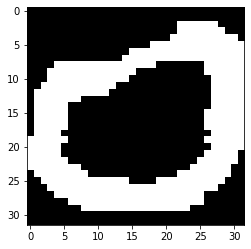

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from matplotlib import cm as cm

def _edge_detect(im):
    return np.max(np.array([_sobel_detect(im[:,:, 0]),_sobel_detect(im[:,:, 1]),_sobel_detect(im[:,:, 2])]), axis=0)


def _sobel_detect(channel): # sobel edge detection
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)

def sort_words(boxes):
    for i in range(1, len(boxes)):
        key = boxes[i]
        j = i - 1
        while(j >= 0 and key[2] < boxes[j][2]):
            boxes[j+1] = boxes[j]
            j -= 1
        boxes[j+1] = key
    return boxes

def sort_boxes(boxes):
    lines = []
    new_lines = []
    tmp_box = boxes[0]
    lines.append(tmp_box)
    for box in boxes[1:]:
        if((box[0] + (box[1] - box[0])/2) < tmp_box[1]):
            lines.append(box)
            tmp_box = box
        else:
            new_lines.append(sort_words(lines))
            lines = []
            tmp_box = box
            lines.append(box)
    new_lines.append(sort_words(lines))
    return(new_lines)

def sort_labels(label_boxes):
    for i in range(1, len(label_boxes)):
        key = label_boxes[i]
        j = i - 1
        while(j >= 0 and key[1][2] < label_boxes[j][1][2]):
            label_boxes[j+1] = label_boxes[j]
            j -= 1
        label_boxes[j+1] = key
    return label_boxes

def scale_boxes(new_img, old_img, coords):
    coords[0] = int((coords[0]) * new_img.shape[0] / old_img.shape[0]); # new top left
    coords[1] = int((coords[1]) * new_img.shape[1] / old_img.shape[1] ); # new bottom left
    coords[2] = int((coords[2] + 1) * new_img.shape[0] / old_img.shape[0]) - 1; # new top right
    coords[3] = int((coords[3] + 1) * new_img.shape[1] / old_img.shape[1] ) - 1; # new bottom right
    return coords

def clipping_image(new):
    colsums = np.sum(new, axis=0)
    linessum = np.sum(new, axis=1)
    colsums2 = np.nonzero(0-colsums)
    linessum2 = np.nonzero(0-linessum)

    x = linessum2[0][0] # top left
    xh = linessum2[0][linessum2[0].shape[0]-1] # bottom left
    y = colsums2[0][0] # top right
    yw = colsums2[0][colsums2[0].shape[0]-1] # bottom right

    imgcrop = new[x:xh, y:yw] # crop the image

    return imgcrop, [x, xh, y, yw]


def padding_resizing_image(img):
    img = cv2.copyMakeBorder(img, 2, 2, 0, 0, cv2.BORDER_CONSTANT) # add 2px padding to image
    try:
        img = cv2.resize(np.uint8(img), (32, 32)) # resize the image to 32*32
    except:
        return img
    finally:
        return img

def segmentation(img, sequence, origimg=None, wordNo=None):
    if(sequence == "word"): # resize to find the words
        width = 940
        height = int(img.shape[0] * (width / img.shape[1]))
        sigma = 18
    elif(sequence == "character"): # resize to find the characters
        width = img.shape[1] # 1280
        height = img.shape[0] # int(img.shape[0] * (width / img.shape[1]))
        sigma = 0

    img = cv2.resize(img, (width, height))
    blurred = cv2.GaussianBlur(img, (5, 5), sigma) # apply gaussian blur

    if(sequence == "word"):
        blurred = _edge_detect(blurred) # edge detect in blurred image (words)
        ret, img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding with Binary
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8)) # Morphological processing - Black&White
        plt.imshow(img)
        plt.show()
    elif(sequence == "character"):
        ret, img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Otsu's thresholding with Binary Inverted
        plt.imshow(img)
        plt.show()

    num_labels, labels_im = cv2.connectedComponents(img) # find the connected components

    if(sequence == "word"):
        boxes = [] # for storing the coordinates of the bounding boxes
        for i in range(1, num_labels):
            new, nr_objects = ndimage.label(labels_im == i) # select the images with label
            new, new_coord = clipping_image(new) # clipping the image to the edges
            if(not(new.shape[0] < 10 or new.shape[1] < 10)):
                boxes.append(new_coord)

    if(sequence == "character"):
        boxes = []
        label_box = []
        for i in range(1, num_labels):
            new, nr_objects = ndimage.label(labels_im == i) # select the images with label
            new, new_coord = clipping_image(new) # clipping the image to the edges
            if(not(new.shape[0] < 10 or new.shape[1] < 10)):
                label_box.append([i, new_coord])
        label_box = sort_labels(label_box) # sort the words
        chNo = 0 
        for box in label_box:
            ch_img, nr_objects = ndimage.label(labels_im == box[0])
            ch_img, new_coord = clipping_image(ch_img)
            cropped_image = padding_resizing_image(ch_img)
            try:
                # dst = "/content/characters/"+str(wordNo)+"_"+str(chNo)+".png"
                plt.imshow(cropped_image, cmap=cm.gray)
                plt.show()
            except:
                pass
            finally:
                pass
            chNo += 1
    return img, boxes

img = cv2.cvtColor(cv2.imread("/content/IMG_20200601_221220~2.jpg"), cv2.COLOR_BGR2RGB) # input image
plt.imshow(img)
plt.show()
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) # opening image to remove minor noise
new_img, boxes = segmentation(img, "word") # line segmentation
boxes.sort()
boxes = sort_boxes(boxes)
scaled_boxes = [] # coordinates values scaled to img
for box in boxes:
    for box in box:
        box = scale_boxes(img, new_img, box)
        scaled_boxes.append(box)
wordNo = 0
for scaled_box in scaled_boxes:
    img_gray = cv2.cvtColor(img[scaled_box[0]:scaled_box[1], scaled_box[2]:scaled_box[3]], cv2.COLOR_BGR2GRAY)
    img_new, _ = segmentation(img_gray, "character", None, wordNo)
    wordNo += 1